In [1]:
import matplotlib.gridspec as gridspec
from appgeopy import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from my_packages import *

#### **Monthly Cumulative Displacements**

#### **Year-by-year Average Velocities**

In [2]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


def convert_column_to_title(select_col):
    start_period, end_period = select_col.split("_")
    start_period = pd.to_datetime(start_period[1:])
    end_period = pd.to_datetime(end_period[1:])
    return start_period.strftime("%Y/%m/%d"), end_period.strftime("%Y/%m/%d")


def create_custom_bounded_colormap(vmin=-10, vmax=5, base_cmap="turbo"):
    """
    Generate custom colormap with precise interval-to-color mapping.

    Args:
        vmin (int): Lower bound of value range
        vmax (int): Upper bound of value range
        base_cmap (str): Reference matplotlib colormap

    Returns:
        ListedColormap: Customized colormap with exact interval mappings
    """
    # Calculate number of distinct intervals needed
    n_intervals = int(vmax - vmin)

    # Extract colors from reference colormap
    base = plt.cm.get_cmap(base_cmap)
    color_samples = np.linspace(0, 1, n_intervals)
    colors = base(color_samples)

    # Create new colormap with exact interval allocation
    custom_cmap = ListedColormap(colors)

    return custom_cmap

supporting shapefiles

In [3]:
huwei_boundary = gpd.read_file(
    r"D:\1000_SCRIPTS\003_Project002\20250423_InSAR_Result_View\shapefiles\huwei_merged_twd97.shp"
)
huwei_science_park_boundary = gpd.read_file(r"shapefiles/huwei_science_park.shp")
huwei_roads = gpd.read_file(r"shapefiles/support/sciencepark_roads_twd97.shp")

measurement shapefiles

#### **2016 --> 2024 Average Velocities**

In [4]:
# all points, in Yunlin
yunlin_points = pd.read_pickle(
    r"yunlin_sbasinsar/All-Time_AverageVelocity_Yunlin.pkl", compression="zip"
)
select_col = "Velocity_mm_yr"

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
velocity_df = yunlin_points.loc[:, [select_col]] / 10
velocity_df = gpd.GeoDataFrame(data=velocity_df, geometry=yunlin_points.geometry)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# points within Huwei polygon
huwei_points = geospatial.find_points_within_polygon(
    points_gdf=velocity_df, polygon_geom=huwei_boundary.geometry
)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# points within the Huwei Science Park
science_park_points = geospatial.find_points_within_polygon(
    points_gdf=velocity_df, polygon_geom=huwei_science_park_boundary.geometry
)

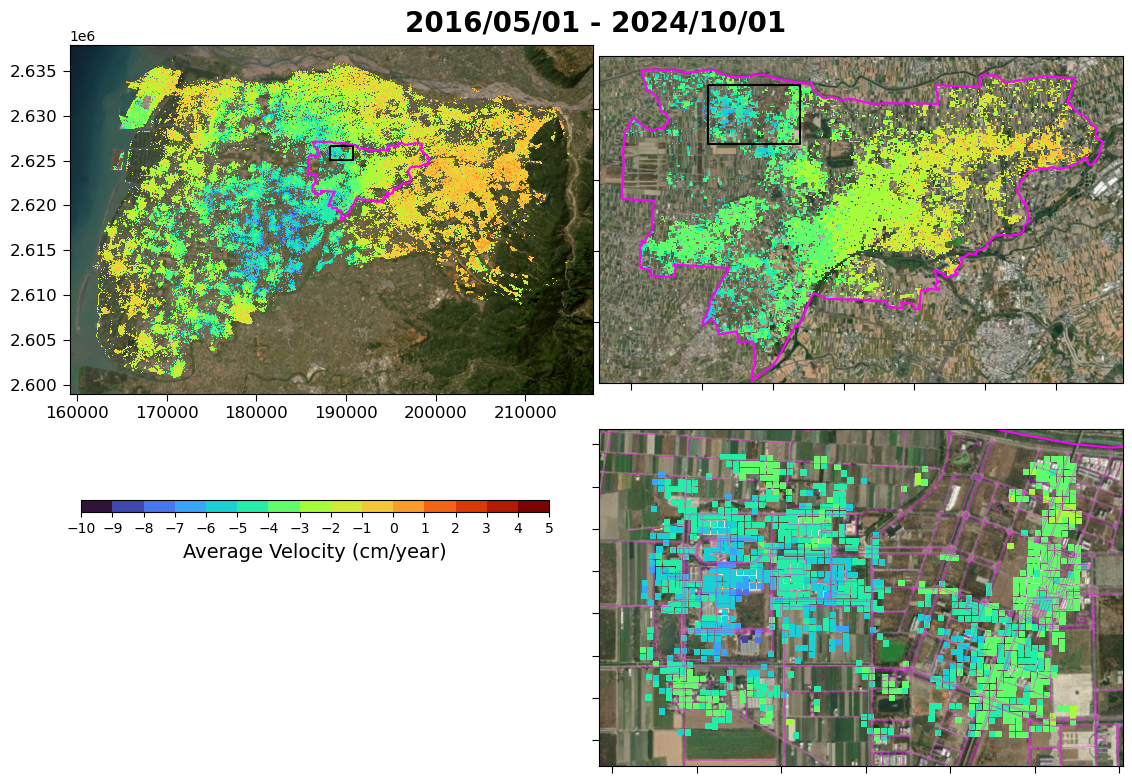

In [5]:
# Main visualization configuration
# select_col = measure_cols[0]
vmin, vmax = [-10, 5]
select_cmap = create_custom_bounded_colormap(vmin=-10, vmax=5, base_cmap='turbo')
# vmin, vmax = velocity_df.loc[:, select_col].quantile(0.01), velocity_df.loc[:, select_col].quantile(
#     0.99
# )
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
fig = plt.figure(figsize=(11.7, 8.3))

# Optimize grid layout with compact spacing parameters
G = gridspec.GridSpec(nrows=4, ncols=8, wspace=0.05, hspace=0.05)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Panel 1: Regional velocity visualization
ax1 = fig.add_subplot(G[:2, :4])

spatial_plot.point_values(
    gdf=velocity_df,
    value_column=select_col,
    ax=ax1,
    cmap=select_cmap,
    edgecolors="none",
    marker="s",
    s=0.5,
    vmin=vmin,
    vmax=vmax,
    show_colorbar=False,
    alpha=1,
)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Panel 2: District-level velocity representation
ax2 = fig.add_subplot(G[:2, 4:])
spatial_plot.point_values(
    gdf=huwei_points,
    value_column=select_col,
    ax=ax2,
    cmap=select_cmap,
    edgecolors="none",
    marker="s",
    s=1,
    vmin=vmin,
    vmax=vmax,
    show_colorbar=False,
    alpha=1,
)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Panel 3: Science park focused view with road network
ax3 = fig.add_subplot(G[2:, 4:])
spatial_plot.show_polylines(
    gdf=huwei_roads, color="fuchsia", linewidth=0.5, alpha=0.5, ax=ax3, zorder=2
)
spatial_plot.point_values(
    gdf=science_park_points,
    value_column=select_col,
    ax=ax3,
    cmap=select_cmap,
    edgecolors="none",
    marker="s",
    s=20,
    vmin=vmin,
    vmax=vmax,
    zorder=1,
    show_colorbar=False,
    alpha=1,
)
spatial_plot.set_plot_bounds(ax3, science_park_points, buffer_factor=0.1)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Apply common styling and basemap configuration to all panels
for k, ax in enumerate([ax1, ax2, ax3]):
    spatial_plot.add_basemap(
        ax, crs="EPSG:3826", zoom="auto", source=ctx.providers.Esri.WorldImagery
    )
    visualize.configure_axis(ax, tick_direction="out", fontsize_base=12)
    spatial_plot.show_polygons(
        gdf=huwei_boundary, facecolor="none", edgecolor="fuchsia", ax=ax, alpha=1, linewidth=1.5
    )

    # Conditional science park boundary rendering
    if k != 2:
        spatial_plot.show_polygons(
            gdf=huwei_science_park_boundary, facecolor="none", ax=ax, alpha=1, linewidth=1.5
        )

    # Suppress tick labels for non-primary panels
    if k in [1, 2]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis="both", which="both", length=5)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
start_period = "2016/05/01"
end_period = "2024/10/01"
fig.suptitle(t=f"{start_period} - {end_period}", ha="center", fontsize=20, fontweight="bold")
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# SOLUTION: Define slim colorbar with explicit positioning
# [left, bottom, width, height] in normalized figure coordinates (0-1)
cbar_ax = fig.add_axes([0.06, 0.375, 0.4, 0.015])  # Thin horizontal bar

# Generate scalar mappable for colorbar
sm = plt.cm.ScalarMappable(cmap=select_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

# Configure colorbar with precise tick positioning
tick_values = np.arange(np.floor(vmin), np.ceil(vmax) + 1, 1.0)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=tick_values)
cbar.set_label(label="Average Velocity (cm/year)", fontsize=14, labelpad=5, loc="center")
cbar.ax.tick_params(labelsize=10)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
visualize.save_figure(fig=fig, savepath=f"fulltime_averagevelocity_yunlin.png", dpi=600)
# plt.close()